## Collection_DS_takehome_challenges: Marketing Email Campaign

### Kanja Saha
### 08/12/2018

The marketing team of an e-commerce site has launched an email campaign. This site has email addresses from all the users who created an account in the past. 

They have chosen a random sample of users and emailed them. The email let the user know about a new feature implemented on the site. From the marketing team perspective, a success is if the user clicks on the link inside of the email. This link takes the user to the company site. 

You are in charge of ﬁguring out how the email campaign performed and were asked the following questions:

- What percentage of users opened the email and what percentage clicked on the link within the email? 
- The VP of marketing thinks that it is stupid to send emails to a random subset and in a random way. Based on all the information you have about the emails that were sent, can you build a model to optimize in future email campaigns to maximize the probability of users clicking on the link inside the email? 
- By how much do you think your model would improve click through rate ( deﬁned as # of users who click on the link / total users who received the email). How would you test that? 
- Did you ﬁnd any interesting pattern on how the email campaign performed for diﬀerent segments of users? Explain.

### Import Libraries & Data Load 

In [1]:
#import necessary libraries
import pandas as pd
import numpy as np
from IPython.display import display
from datetime import datetime
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from time import time
import matplotlib.patches as mpatches
# Import supplementary visualization code visuals.py
import visuals as vs

email_opened_table=pd.read_csv('email_opened_table.csv')
link_clicked_table=pd.read_csv('link_clicked_table.csv')
email_table=pd.read_csv('email_table.csv')


In [2]:
display(email_opened_table.head())
display(link_clicked_table.head())
display(email_table.head())

,email_id
0,284534
1,609056
2,220820
3,905936
4,164034


,email_id
0,609056
1,870980
2,935124
3,158501
4,177561


,email_id,email_text,email_version,hour,weekday,user_country,user_past_purchases
0,85120,short_email,personalized,2,Sunday,US,5
1,966622,long_email,personalized,12,Sunday,UK,2
2,777221,long_email,personalized,11,Wednesday,US,2
3,493711,short_email,generic,6,Monday,UK,1
4,106887,long_email,generic,14,Monday,US,6


In [3]:
#merged the three dataframes
from functools import reduce
link_clicked_table['clicked']=1
email_opened_table['opened']=1
df = [email_table, email_opened_table, link_clicked_table]
df_merged= reduce(lambda  left,right: pd.merge(left,right,on=['email_id'],
                                            how='outer'), df).fillna(0)
display(df_merged.head())
df_merged.describe()



,email_id,email_text,email_version,hour,weekday,user_country,user_past_purchases,opened,clicked
0,85120,short_email,personalized,2,Sunday,US,5,0.0,0.0
1,966622,long_email,personalized,12,Sunday,UK,2,1.0,1.0
2,777221,long_email,personalized,11,Wednesday,US,2,0.0,0.0
3,493711,short_email,generic,6,Monday,UK,1,0.0,0.0
4,106887,long_email,generic,14,Monday,US,6,0.0,0.0


,email_id,hour,user_past_purchases,opened,clicked
count,100000.000000,100000.000000,100000.00000,100000.000000,100000.000000
mean,498690.196160,9.059300,3.87845,0.103450,0.021190
std,289230.727534,4.439637,3.19611,0.304547,0.144018
min,8.000000,1.000000,0.00000,0.000000,0.000000
25%,246708.250000,6.000000,1.00000,0.000000,0.000000
50%,498447.000000,9.000000,3.00000,0.000000,0.000000
75%,749942.750000,12.000000,6.00000,0.000000,0.000000
max,999998.000000,24.000000,22.00000,1.000000,1.000000


### Question 1
What percentage of users opened the email and what percentage clicked on the link within the email?

In [4]:
clicked_percent=df_merged['clicked'].sum().astype(float)/df_merged['email_id'].count()
opened_percent=df_merged['opened'].sum().astype(float)/df_merged['email_id'].count()
print ("{0:.2%} of users opened the email and {1:.2%} of users clicked on the link within the email".format(opened_percent,clicked_percent))

10.35% of users opened the email and 2.12% of users clicked on the link within the email


## Question 2
The VP of marketing thinks that it is stupid to send emails to a random subset and in a random way. Based on all the information you have about the emails that were sent, can you build a model to optimize in future email campaigns to maximize the probability of users clicking on the link inside the email? 

### 2.a Exploratory Data Analysis and Preprocessing

The task in hand is a binary classification task i.e. whether the user will click the link inside the email.
The dataset consists of mostly categorical and one very important(user_purchase_history) numerical feature. The categorical features are converted into binary features using get_dummies function.

Observations after exploratory data analysis:
- Click rate is highest aroun 11pm with two surge around 10 am-12 noon and then 3pm-4pm
- Click rate is higher during weekdays with weekend a bit lower and then Friday with the lowest click rate
- Click rate is considerable higher in US and UK compared to Spain and France
- Short email and personalized emails did better than long and generic email. 

Anomaly in data:
- In general, the clickrate and opened rate increased with past purchase but there is no information on opened rate for users who bought 20 products. Since click and open rate are same for users who have bought more than 18 products, we will assume that the open rate is same as click rate for users who bought 20 products

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x0000027059BCFE10>,
      dtype=object)

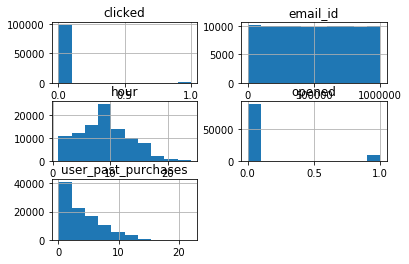

In [5]:
df_merged.hist()

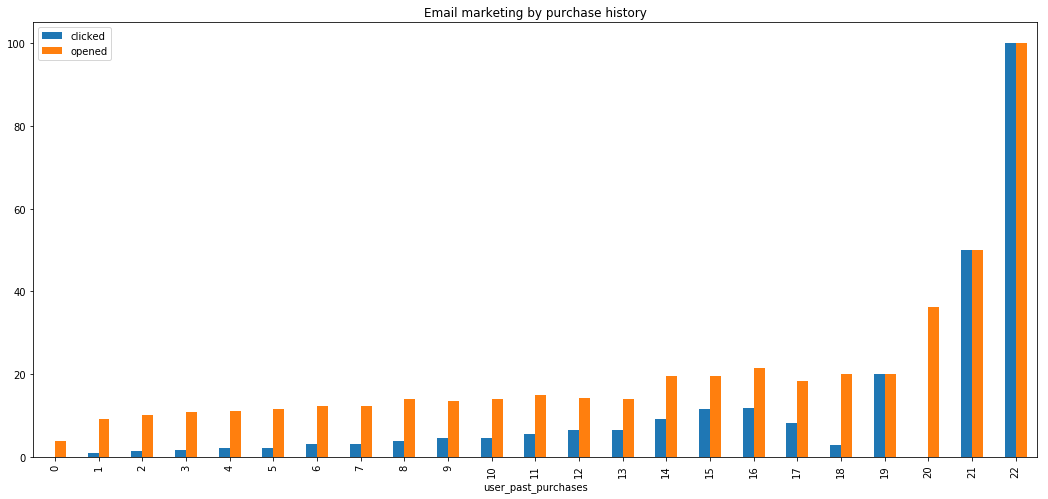

In [6]:
df_purchasehistory1=df_merged.groupby(['user_past_purchases'])["clicked", "opened"].apply(lambda x : x.astype(int).sum()*100/x.astype(int).count())
df_purchasehistory1.plot(kind='bar',figsize=(18,8),  title='Email marketing by purchase history',legend=True)

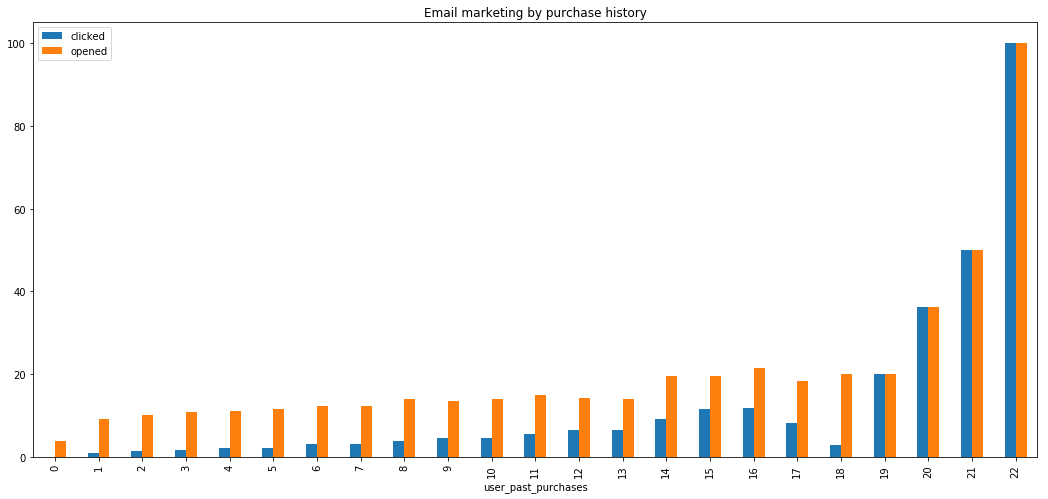

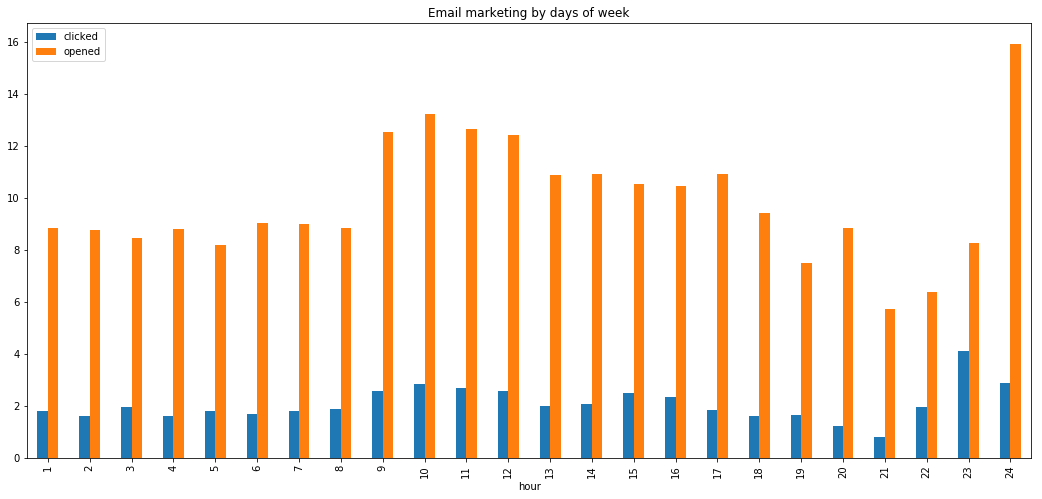

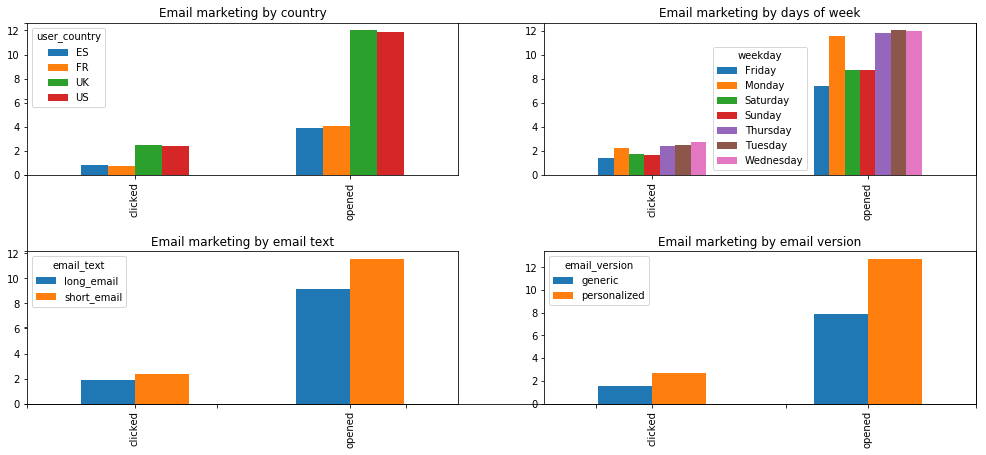

In [7]:
df_merged.loc[(df_merged.user_past_purchases ==20) & (df_merged.opened ==1), 'clicked'] = 1.0
df_country=df_merged.groupby(['user_country'])["clicked", "opened"].apply(lambda x : x.astype(int).sum()*100/x.astype(int).count())
df_dayofweek=df_merged.groupby(['weekday'])["clicked", "opened"].apply(lambda x : x.astype(int).sum()*100/x.astype(int).count())
df_hour=df_merged.groupby(['hour'])["clicked", "opened"].apply(lambda x : x.astype(int).sum()*100/x.astype(int).count())
df_emailtext=df_merged.groupby(['email_text'])["clicked", "opened"].apply(lambda x : x.astype(int).sum()*100/x.astype(int).count())
df_emailversion=df_merged.groupby(['email_version'])["clicked", "opened"].apply(lambda x : x.astype(int).sum()*100/x.astype(int).count())
df_purchasehistory=df_merged.groupby(['user_past_purchases'])["clicked", "opened"].apply(lambda x : x.astype(int).sum()*100/x.astype(int).count())

df_purchasehistory.plot(kind='bar',figsize=(18,8),  title='Email marketing by purchase history',legend=True)
df_hour.plot(kind='bar',figsize=(18,8),  title='Email marketing by days of week',legend=True)

plt.figure()

# Now switch to a more OO interface to exercise more features.
fig, axs = plt.subplots(sharex=False,sharey=False)
plt.setp(axs.get_yticklabels(), visible=False)
plt.setp(axs.get_xticklabels(), visible=False)

fig.set_figheight(7)
fig.set_figwidth(17)
fig.subplots_adjust(hspace=.5)
ax1 = fig.add_subplot(221)
df_country.transpose().plot(kind='bar', legend=True,  ax=ax1)
ax1.set_title('Email marketing by country')

ax2 = fig.add_subplot(222)
df_dayofweek.transpose().plot(kind='bar',  legend=True,ax=ax2)
ax2.set_title('Email marketing by days of week')

ax3 = fig.add_subplot(223)
df_emailtext.transpose().plot(kind='bar',  legend=True,ax=ax3)
ax3.set_title('Email marketing by email text')

ax3 = fig.add_subplot(224)
df_emailversion.transpose().plot(kind='bar',  legend=True,ax=ax3)
ax3.set_title('Email marketing by email version')
plt.show()


In [8]:
df_dummy=pd.get_dummies(df_merged, columns=['user_country', 'weekday','email_text','email_version','hour'])
df_dummy.head()

,email_id,user_past_purchases,opened,clicked,user_country_ES,user_country_FR,user_country_UK,user_country_US,weekday_Friday,weekday_Monday,...,hour_15,hour_16,hour_17,hour_18,hour_19,hour_20,hour_21,hour_22,hour_23,hour_24
0,85120,5,0.0,0.0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
1,966622,2,1.0,1.0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,777221,2,0.0,0.0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
3,493711,1,0.0,0.0,0,0,1,0,0,1,...,0,0,0,0,0,0,0,0,0,0
4,106887,6,0.0,0.0,0,0,0,1,0,1,...,0,0,0,0,0,0,0,0,0,0


### 2b Select 3 models based on data distribution and features

We have one numerical discrete variable and multiple categorical variables. Since Decison trees work well with both categorical and numerical variables and simple to understand, I will first try Decision Trees and its ensemble method, RandomForest. I will also implement KNN Classifier as they tend to work well with mixed datatype.

In [9]:
# Since we are trying to predict whether a user will open an email, we can drop the clicked feature.
# It will be a different project to find out how we can improve the email content to improve the click to open ratio.
opened = df_dummy['opened']
df_dummy.drop(['opened'], inplace=True,axis = 1)
email_id = df_dummy['email_id']
df_dummy.drop(['email_id'], inplace=True,axis = 1)
# Split the data into features and target label

clicked = df_dummy['clicked']
features = df_dummy.drop('clicked', axis = 1)


### 2c Prepare Train and Test Data by splitting

In [10]:
# Import train_test_split
from sklearn.cross_validation import train_test_split

# Split the 'features' and 'income' data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(features, 
                                                    clicked, 
                                                    test_size = 0.2, 
                                                    random_state = 0)

# Show the results of the split
print ("Training set has {} samples.".format(X_train.shape[0]))
print ("Testing set has {} samples.".format(X_test.shape[0]))

Training set has 80000 samples.
Testing set has 20000 samples.


C:\Users\kanja\Anaconda3\envs\py35\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


### 2d. Create a training and predicting pipeline
To properly evaluate the performance of each model I created a a training and predicting pipeline that allows me  to quickly and effectively train models using various sizes of training data and perform predictions on the testing data. This function will be used in the following section.
In the code block below, I implemented the following:
 - Import `fbeta_score` and `accuracy_score` from [`sklearn.metrics`](http://scikit-learn.org/stable/modules/classes.html#sklearn-metrics-metrics).
 - Fit the learner to the sampled training data and record the training time.
 - Perform predictions on the test data `X_test`, and also on the first 300 training points `X_train[:300]`.
   - Record the total prediction time.
 - Calculate the accuracy score for both the training subset and testing set.
 - Calculate the F-score for both the training subset and testing set.
  

In [11]:
# TODO: Import two metrics from sklearn - fbeta_score and accuracy_score
from sklearn.metrics import fbeta_score,accuracy_score,f1_score
from sklearn.metrics import confusion_matrix

def train_predict(learner, sample_size, X_train, y_train, X_test, y_test): 
    '''
    inputs:
       - learner: the learning algorithm to be trained and predicted on
       - sample_size: the size of samples (number) to be drawn from training set
       - X_train: features training set
       - y_train: income training set
       - X_test: features testing set
       - y_test: income testing set
    '''
    
    results = {}
    
    start = time() # Get start time
    learner = learner.fit(X_train[:sample_size], y_train[:sample_size])
    end = time() # Get end time
    
    # TODO: Calculate the training time
    results['train_time'] = end - start
        
    # TODO: Get the predictions on the test set(X_test),
    start = time() # Get start time
    predictions_test = learner.predict(X_test)
    predictions_train = learner.predict(X_train)
    end = time() # Get end time
    
    results['pred_time'] = end - start
            
    results['acc_train'] = accuracy_score(y_train,predictions_train)
        
    results['acc_test'] = accuracy_score(y_test,predictions_test)
    
    results['f_train'] = fbeta_score(y_train,predictions_train,.5)
        
    results['f_test'] = fbeta_score(y_test,predictions_test,.5)
    
    labels = [0,1]
    cm_train = confusion_matrix(y_train, predictions_train, labels)
    cm_test = confusion_matrix(y_test, predictions_test, labels)
    display(learner)
    display(cm_train)
    display(cm_test)
       
    # Success
    print ("{} trained on {} samples.".format(learner.__class__.__name__, sample_size))
        
    # Return the results
    return results

In [12]:
def evaluate(results):
    """
    Visualization code to display results of various learners.
    
    inputs:
      - learners: a list of supervised learners
      - stats: a list of dictionaries of the statistic results from 'train_predict()'
      
    """
  
    # Create figure
    fig, ax = plt.subplots(2, 3, figsize = (11,7))

    # Constants
    bar_width = 0.3
    colors = ['#A00000','#00A0A0','#00A000']
    
    # Super loop to plot four panels of data
    for k, learner in enumerate(results.keys()):
        for j, metric in enumerate(['train_time', 'acc_train', 'f_train', 'pred_time', 'acc_test', 'f_test']):
            for i in np.arange(3):
                
                # Creative plot code
                ax[j//3, j%3].bar(i+k*bar_width, results[learner][i][metric], width = bar_width, color = colors[k])
                ax[j//3, j%3].set_xticks([0.45, 1.45, 2.45])
                ax[j//3, j%3].set_xticklabels(["1%", "10%", "100%"])
                ax[j//3, j%3].set_xlabel("Set Size")
                ax[j//3, j%3].set_xlim((-0.1, 3.0))
    
    # Add unique y-labels
    ax[0, 0].set_ylabel("Time (in seconds)")
    ax[0, 1].set_ylabel("Accuracy Score")
    ax[0, 2].set_ylabel("F-score")
    ax[1, 0].set_ylabel("Time (in seconds)")
    ax[1, 1].set_ylabel("Accuracy Score")
    ax[1, 2].set_ylabel("F-score")
    
    # Add titles
    ax[0, 0].set_title("Model Training")
    ax[0, 1].set_title("Accuracy Score on Training Set")
    ax[0, 2].set_title("F-score on Training Set")
    ax[1, 0].set_title("Model Predicting")
    ax[1, 1].set_title("Accuracy Score on Testing Set")
    ax[1, 2].set_title("F-score on Testing Set")
    
      
    # Set y-limits for score panels
    ax[0, 1].set_ylim((0, 1))
    ax[0, 2].set_ylim((0, 1))
    ax[1, 1].set_ylim((0, 1))
    ax[1, 2].set_ylim((0, 1))

    # Create patches for the legend
    patches = []
    for i, learner in enumerate(results.keys()):
        patches.append(mpatches.Patch(color = colors[i], label = learner))
    plt.legend(handles = patches, bbox_to_anchor = (-.80, 2.53), \
               loc = 'upper center', borderaxespad = 0., ncol = 3, fontsize = 'x-large')
    
    # Aesthetics
    plt.suptitle("Performance Metrics for Three Supervised Learning Models", fontsize = 16, y = 1.10)
    plt.tight_layout()
    plt.show()
    


DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

array([[76246,  2044],
       [ 1599,   111]], dtype=int64)

array([[19056,   531],
       [  393,    20]], dtype=int64)

DecisionTreeClassifier trained on 800 samples.


DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

array([[77003,  1287],
       [ 1537,   173]], dtype=int64)

array([[19209,   378],
       [  390,    23]], dtype=int64)

DecisionTreeClassifier trained on 8000 samples.


DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

array([[78284,     6],
       [ 1468,   242]], dtype=int64)

array([[19499,    88],
       [  408,     5]], dtype=int64)

DecisionTreeClassifier trained on 80000 samples.


KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='uniform')

array([[78287,     3],
       [ 1710,     0]], dtype=int64)

array([[19583,     4],
       [  413,     0]], dtype=int64)

KNeighborsClassifier trained on 800 samples.


KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='uniform')

array([[78233,    57],
       [ 1695,    15]], dtype=int64)

array([[19564,    23],
       [  410,     3]], dtype=int64)

KNeighborsClassifier trained on 8000 samples.


KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='uniform')

array([[78265,    25],
       [ 1679,    31]], dtype=int64)

array([[19577,    10],
       [  413,     0]], dtype=int64)

KNeighborsClassifier trained on 80000 samples.


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

array([[77976,   314],
       [ 1672,    38]], dtype=int64)

array([[19489,    98],
       [  411,     2]], dtype=int64)

RandomForestClassifier trained on 800 samples.


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

array([[77761,   529],
       [ 1592,   118]], dtype=int64)

array([[19433,   154],
       [  406,     7]], dtype=int64)

RandomForestClassifier trained on 8000 samples.


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

array([[78222,    68],
       [ 1472,   238]], dtype=int64)

array([[19510,    77],
       [  408,     5]], dtype=int64)

RandomForestClassifier trained on 80000 samples.


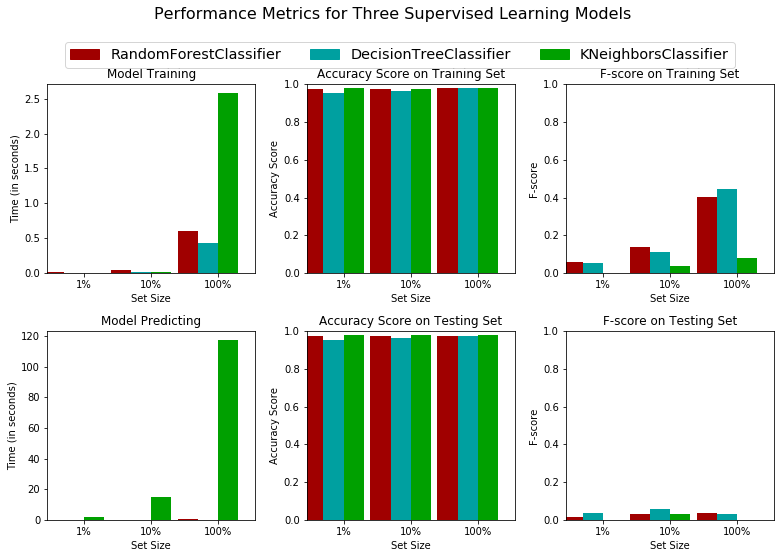

In [13]:

# TODO: Initialize the three models
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier

#clf_A = DecisionTreeClassifier(max_depth=6,min_samples_leaf =40)
clf_A = DecisionTreeClassifier()
clf_B = KNeighborsClassifier()
clf_C= RandomForestClassifier()


# TODO: Calculate the number of samples for 1%, 10%, and 100% of the training data
# HINT: samples_100 is the entire training set i.e. len(y_train)
# HINT: samples_10 is 10% of samples_100
# HINT: samples_1 is 1% of samples_100
samples_100 = len(y_train)
samples_10 = (samples_100//10)
samples_1 = samples_100//100


# Collect results on the learners
results = {}
for clf in [clf_A, clf_B, clf_C]:
    clf_name = clf.__class__.__name__
    results[clf_name] = {}
    
    for i, samples in enumerate([samples_1, samples_10, samples_100]):
        results[clf_name][i] = \
        train_predict(clf, samples, X_train, y_train, X_test, y_test)

# Run metrics visualization for the three supervised learning models chosen
evaluate(results)

After going over the F-score and Confuion Matrix, it can be said that RandomForestClassifier has the best prediction of all, although I am concerned that the F Score went down with the increas of sample size. There is also a chance that the model is overfitting as test score is much lower than training score.

If we look at the confusion matrix below, we see that the False Positive Score is 69 and and False Negative Score is 407 and True Positive is only 6 while the test set has 413 positives.

I will still take the RandomForestClassifier and tune it with new dataset that is a unique combination of all the 6 variables:
email_text,email_version,hour,weekday,user_country,user_past_purchases


In [14]:
y_test.sum()

413.0

In [15]:
results[clf_C]=train_predict(clf_C, 800000, X_train, y_train, X_test, y_test)


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

array([[78220,    70],
       [ 1461,   249]], dtype=int64)

array([[19517,    70],
       [  409,     4]], dtype=int64)

RandomForestClassifier trained on 800000 samples.


### 2e. Select the best model and tune parameters

Since this dataset has rare positives, accuracy score is not much of use and we need to rely on fbeta score, which is a harmonic mean of precision and recall.

I chose RandomForestClassifier to tune. RandomForestClassifier had the best F score value of the three model with full data set. 

I used grid search (`GridSearchCV`) with n_estimators, min_sample_leaf,max_features at 3 different values. 

In [16]:
from sklearn.metrics import make_scorer
from sklearn.grid_search import GridSearchCV 
 
clf= clf_C #RandomForestClassifier

parameters = {'min_samples_leaf':[30,50,100,200,300], 'n_estimators':[100,500,1000,700],'max_features':["log2","sqrt","auto"]}

# TODO: Make an fbeta_score scoring object using make_scorer()
scorer = make_scorer(fbeta_score, beta=.5)

# TODO: Perform grid search on the classifier using 'scorer' as the scoring method using GridSearchCV()
grid_obj = GridSearchCV(clf,parameters,scorer)


# TODO: Fit the grid search object to the training data and find the optimal parameters using fit()
grid_fit = grid_obj.fit(X_train,y_train)

# Get the estimatorc
best_clf = grid_fit.best_estimator_
best_params=grid_fit.best_params_


# Make predictions using the unoptimized and the optimized model 
predictions = (clf.fit(X_train, y_train)).predict(X_test)
best_predictions = best_clf.predict(X_test)

# Report the before-and-afterscores
print ("Unoptimized model\n------")
print ("Accuracy score on testing data: {:.4f}".format(accuracy_score(y_test, predictions)))
print ("F-score on testing data: {:.4f}".format(fbeta_score(y_test, predictions, beta = 0.5)))
print ("\nOptimized Model\n------")
print ("Final accuracy score on the testing data: {:.4f}".format(accuracy_score(y_test, best_predictions)))
print ("Final F-score on the testing data: {:.4f}".format(fbeta_score(y_test, best_predictions, beta = 0.5)))
print ("Best estimator parameters")
print (best_params)

C:\Users\kanja\Anaconda3\envs\py35\lib\site-packages\sklearn\grid_search.py:42: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)
C:\Users\kanja\Anaconda3\envs\py35\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\kanja\Anaconda3\envs\py35\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\kanja\Anaconda3\envs\py35\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', aver

C:\Users\kanja\Anaconda3\envs\py35\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\kanja\Anaconda3\envs\py35\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\kanja\Anaconda3\envs\py35\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\kanja\Anaconda3\envs\py35\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\kanja\Anaconda3\envs\py35\lib\site-packages

C:\Users\kanja\Anaconda3\envs\py35\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\kanja\Anaconda3\envs\py35\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\kanja\Anaconda3\envs\py35\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\kanja\Anaconda3\envs\py35\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\kanja\Anaconda3\envs\py35\lib\site-packages

C:\Users\kanja\Anaconda3\envs\py35\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\kanja\Anaconda3\envs\py35\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\kanja\Anaconda3\envs\py35\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\kanja\Anaconda3\envs\py35\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\kanja\Anaconda3\envs\py35\lib\site-packages

C:\Users\kanja\Anaconda3\envs\py35\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\kanja\Anaconda3\envs\py35\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\kanja\Anaconda3\envs\py35\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\kanja\Anaconda3\envs\py35\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\kanja\Anaconda3\envs\py35\lib\site-packages

C:\Users\kanja\Anaconda3\envs\py35\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\kanja\Anaconda3\envs\py35\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\kanja\Anaconda3\envs\py35\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\kanja\Anaconda3\envs\py35\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\kanja\Anaconda3\envs\py35\lib\site-packages

Unoptimized model
------
Accuracy score on testing data: 0.9759
F-score on testing data: 0.0210

Optimized Model
------
Final accuracy score on the testing data: 0.9794
Final F-score on the testing data: 0.0000
Best estimator parameters
{'max_features': 'log2', 'n_estimators': 100, 'min_samples_leaf': 30}


C:\Users\kanja\Anaconda3\envs\py35\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


### 2f Choose unique combination of the 6 features and get the predicted value using the best model

In [17]:
df_dummy.drop_duplicates()

uc_features = df_dummy.drop(['clicked'], axis = 1)
predictions_test = best_clf.predict(uc_features)
uc_features['clicked_predicted']=predictions_test

uc_features['user_past_purchases']=np.where(uc_features['user_past_purchases']==0, 0, 1)

In [18]:
from itertools import groupby
import re

def back_from_dummies(df):
    result_series = {}
    result_series2 = {}
   
    # Find non-dummy columns that do not have a _
    non_dummy_cols = ['user_past_purchases','clicked_predicted']
    d_hour = [(col.split("_")[0],col) for col in df.columns if "hour" in col]
    d_weekday = [(col.split("_")[0],col) for col in df.columns if "weekday" in col]
    d_uc = [(re.search('(.*?_.*?)_', col).group(1),col) for col in df.columns if "user_country" in col] 
    d_text = [(re.search('(.*?_.*?)_', col).group(1),col) for col in df.columns if "email_text" in col]
    d_version = [(re.search('(.*?_.*?)_', col).group(1),col) for col in df.columns if "email_version" in col]
    dummmy_tuples1 = d_hour+d_weekday
    dummmy_tuples2 = d_uc+d_text+d_version
    #display(d_uc)

    # For each category column group use idxmax to find the value.
    for dummy, cols in groupby(dummmy_tuples1, lambda item: item[0]):
        
        
        #Select columns for each category
        dummy_df = df[[col[1] for col in cols]]
        #display (dummy_df)
        # Find max value among columns
        max_columns = dummy_df.idxmax(axis=1)
        
        # Remove category_ prefix
        result_series[dummy] = max_columns.apply(lambda item: item.split("_")[1])
        
    for dummy, cols in groupby(dummmy_tuples2, lambda item: item[0]):
        
        
        #Select columns for each category
        dummy_df = df[[col[1] for col in cols]]
        #display (dummy_df)
        # Find max value among columns
        max_columns = dummy_df.idxmax(axis=1)
        
        # Remove category_ prefix
        result_series2[dummy] = max_columns.apply(lambda item: item.split("_")[2])

        result_series.update(result_series2)
    # Copy non-dummy columns over.
    for col in non_dummy_cols:
        result_series[col] = df[col]

    # Return dataframe of the resulting series
    return pd.DataFrame(result_series)

final=back_from_dummies(uc_features)
final.head()

,clicked_predicted,email_text,email_version,hour,user_country,user_past_purchases,weekday
0,0.0,short,personalized,2,US,1,Sunday
1,0.0,long,personalized,12,UK,1,Sunday
2,0.0,long,personalized,11,US,1,Wednesday
3,0.0,short,generic,6,UK,1,Monday
4,0.0,long,generic,14,US,1,Monday


### 2g. Based on the model, find the hour/weekday/emailtext/version combination with highest CTR

Since user_country and user_past_purchase cannot be modified, we will choose the combination with highest CTR for this user_country/purchase combination.

In [19]:
final_grouped=final.groupby(['user_past_purchases','user_country','hour','email_text','email_version','weekday']).size().reset_index(name='counts')
df=pd.DataFrame(final_grouped.loc[final_grouped.groupby(['user_past_purchases','user_country'])["counts"].idxmax()]) 

print("Based on the model I bult above, the following combinations of email_text,email_version,weekday,hour will have the highest CTR.")
df

Based on the model I bult above, the following combinations of email_text,email_version,weekday,hour will have the highest CTR.


,user_past_purchases,user_country,hour,email_text,email_version,weekday,counts
386,0,ES,7,long,generic,Sunday,12
490,0,FR,10,long,generic,Friday,9
1006,0,UK,11,short,personalized,Saturday,19
2030,0,US,8,long,generic,Wednesday,37
2123,1,ES,10,short,generic,Monday,41
2724,1,FR,10,short,generic,Sunday,41
3823,1,UK,6,short,personalized,Tuesday,69
3941,1,US,10,long,generic,Thursday,186


### Question 3
By how much do you think your model would improve click through rate ( deﬁned as # of users who click on the link / total users who received the email). How would you test that? 

 
I think my model click thru rate will be doubled to around 20%.

I will check the clicked/opened of all rows where the 6 features matches any of the 8 combinations of the 6 features above.
Solution below

In [20]:
df_merged_email_opened=df_merged[(df_merged.opened==1)]
df_merged_email_opened['user_past_purchases']=np.where(df_merged_email_opened['user_past_purchases']==0, 0, 1)
df_merged_email_opened['email_text']=np.where(df_merged_email_opened['email_text']=='short_email', 'short', 'long')
df['hour'] = df['hour'].astype(np.int64)
new_df = pd.merge(df_merged_email_opened, df,  how='inner', left_on=['user_country','user_past_purchases','email_text','email_version','weekday','hour'], right_on = ['user_country','user_past_purchases','email_text','email_version','weekday','hour'])
clicked_percent_of_open=new_df['clicked'].sum().astype(float)/new_df['opened'].sum().astype(float)

print ("{0:.2%} of users who opened the email also clicked on the link within the email".format(clicked_percent_of_open))

21.74% of users who opened the email also clicked on the link within the email


C:\Users\kanja\Anaconda3\envs\py35\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
C:\Users\kanja\Anaconda3\envs\py35\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


### Question 4
Did you ﬁnd any interesting pattern on how the email campaign performed for diﬀerent segments of users? Explain.

- Most countries prefer long email 
- Most countries prefer personalized email
- Most prefer weekend emails
- Except US, the other three countries have differnt preferred days based on they are existing customers or no
- All groups houever prefer to read their email in the morning

